In [0]:
# Information necessary to grab API (Application Programming Interface)
username ='OOIAPI-NAL2K3VMHB06OA'
token = 'TEMP-TOKEN-68QRXA825THDH4'
API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In [0]:
# First, let's import the Python libraries we will need
import requests
import datetime
import matplotlib.pyplot as plt

In [0]:
import requests
import time

In [0]:
# Input the Instrument Information for the instrument of interest (can be found on the OOI data website)
subsite = 'GA01SUMO'  #the site of the insturment?
node = 'SBD12'    
sensor = '05-WAVSSA000'
method = 'recovered_host'
stream = 'wavss_a_dcl_statistics_recovered' 
beginDT = '2015-03-15T21:25:00.000Z' 
endDT = '2018-01-14T10:24:00.000Z'





In [0]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [216]:
data['allURLs'][0]

u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/hpotter@tamu.edu/20180524T181631-GA01SUMO-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/catalog.html'

In [10]:
!pip install xarray
!pip install netCDF4
!pip install bokeh
!pip install dask

    100% |████████████████████████████████| 440kB 6.4MB/s 
    100% |████████████████████████████████| 3.6MB 6.8MB/s 
    100% |████████████████████████████████| 3.3MB 7.3MB/s 
  Running setup.py bdist_wheel for cftime ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/10/32/0a/47d6323be1b72a6f4852f861f03ba69e826ba51aa6cfd2430b
Successfully built cftime
    100% |████████████████████████████████| 14.7MB 1.5MB/s 
  Running setup.py bdist_wheel for bokeh ... - \

 | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/ff/28/51/22e8d08e9d5383ee1de981aaa8ff7bc53c7d65022e5101400f
Successfully built bokeh
    100% |████████████████████████████████| 2.3MB 7.3MB/s 
  Running setup.py bdist_wheel for dask ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/8d/5d/b0/de56f34b25bc30bc140d5125429b73222ffb25c8260e8b141d
Successfully built dask


In [11]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 5.77 s, sys: 493 ms, total: 6.26 s
Wall time: 10min 38s


In [0]:
import re
import xarray as xr
import pandas as pd
import os

In [13]:
#Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file.

url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/hpotter@tamu.edu/20180524T133516-GA01SUMO-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/deployment0003_GA01SUMO-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered_20161027T020748.291000-20180114T100751.930000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/hpotter@tamu.edu/20180524T133516-GA01SUMO-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/deployment0002_GA01SUMO-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered_20151114T210746.415000-20161108T090749.584000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/hpotter@tamu.edu/20180524T133516-GA01SUMO-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered/deployment0001_GA01SUMO-SBD12-05-WAVSSA000-recovered_host-wavss_a_dcl_statistics_recovered_20150315T222303.347000-20151126T092303.865000.nc']

In [14]:
# load all the files into a single xarray data set

ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds


<xarray.Dataset>
Dimensions:                              (time: 25120)
Coordinates:
    obs                                  (time) int64 dask.array<shape=(25120,), chunksize=(25120,)>
  * time                                 (time) datetime64[ns] 2015-03-15T22:23:03.347000320 ...
    lat                                  (time) float64 dask.array<shape=(25120,), chunksize=(25120,)>
    lon                                  (time) float64 dask.array<shape=(25120,), chunksize=(25120,)>
Data variables:
    deployment                           (time) int32 dask.array<shape=(25120,), chunksize=(25120,)>
    id                                   (time) |S64 dask.array<shape=(25120,), chunksize=(25120,)>
    average_wave_height                  (time) float32 dask.array<shape=(25120,), chunksize=(25120,)>
    date_string                          (time) object dask.array<shape=(25120,), chunksize=(25120,)>
    dcl_controller_timestamp             (time) object dask.array<shape=(25120,), chunksi

In [128]:
ds2 = ds.sel(time=slice('2016-03-01', '2016-11-01'))
ds2.time

<xarray.DataArray 'time' (time: 5741)>
array(['2016-03-01T00:07:46.761999872', '2016-03-01T01:07:46.776999936',
       '2016-03-01T02:07:46.789000192', ..., '2016-11-01T22:07:50.105999872',
       '2016-11-01T23:07:48.239000576', '2016-11-01T23:07:50.135999488'],
      dtype='datetime64[ns]')
Coordinates:
    obs      (time) int64 dask.array<shape=(5741,), chunksize=(5741,)>
  * time     (time) datetime64[ns] 2016-03-01T00:07:46.761999872 ...
    lat      (time) float64 dask.array<shape=(5741,), chunksize=(5741,)>
    lon      (time) float64 dask.array<shape=(5741,), chunksize=(5741,)>
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T

In [15]:
import pandas as pd

# find the time between values i.e. recording frequency
df = ds.to_dataframe()
res = (pd.Series(df.index[1:]) - pd.Series(df.index[:-1])).value_counts()
res

01:00:00.032999    161
01:00:00.025999    141
00:59:59.032999    136
00:59:59.030000    126
00:59:59.031000    126
01:00:01.032999    117
01:00:00.030000    113
01:00:00.032000    113
01:00:00.031000    111
01:00:00.029000    108
00:59:59.025999    103
01:00:01.034999    102
00:59:59.038000    102
01:00:01.027999    101
01:00:00.029999    100
01:00:00.027999     99
01:00:01.031000     98
01:00:00.024000     97
01:00:00.028000     97
01:00:00.034999     97
00:59:59.027999     95
01:00:00.023000     94
01:00:00.024999     94
00:59:59.032000     91
01:00:00.026999     91
00:59:59.029000     90
01:00:00.022000     90
01:00:01.040000     87
01:00:01.024000     86
01:00:01.025999     85
                  ... 
01:00:00.086000      1
01:00:02.266999      1
01:00:00.949999      1
01:00:03.100000      1
01:00:07.006000      1
00:59:59.948000      1
00:00:04.112000      1
00:15:21.362000      1
00:59:58.069000      1
01:00:00.089999      1
00:00:03.901999      1
00:00:02.162999      1
00:00:02.76

In [0]:
import matplotlib.pyplot as plt

In [0]:
# extract just the data into an array that can then be manipulated

wv_d = ds['mean_direction'].values
Hs = ds['significant_wave_height'].values
Hmax = ds['max_wave_height'].values
t = ds['time'].values
wv_p = ds['mean_wave_period'].values    
wv_spd = ds['mean_spread'].values


In [0]:
# extract just the data into an array that can then be manipulated

wv_d2 = ds2['mean_direction'].values
Hs2 = ds2['significant_wave_height'].values
Hmax2 = ds2['max_wave_height'].values
t2 = ds2['time'].values

(array([8.000e+00, 0.000e+00, 1.000e+01, 2.900e+01, 2.050e+02, 8.580e+02,
        1.561e+03, 2.045e+03, 2.081e+03, 2.236e+03, 2.477e+03, 2.121e+03,
        2.018e+03, 1.837e+03, 1.480e+03, 1.112e+03, 9.800e+02, 8.100e+02,
        6.130e+02, 5.310e+02, 4.560e+02, 3.270e+02, 2.590e+02, 2.350e+02,
        1.800e+02, 1.540e+02, 1.080e+02, 9.400e+01, 6.500e+01, 6.200e+01,
        3.200e+01, 2.700e+01, 2.000e+01, 1.600e+01, 1.400e+01, 9.000e+00,
        9.000e+00, 4.000e+00, 7.000e+00, 7.000e+00, 6.000e+00, 2.000e+00,
        5.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00]),
 array([ 0.        ,  0.23299999,  0.46599998,  0.69899998,  0.93199997,
         1.16499996,  1.39799995,  1.63099995,  1.86399994,  2.09699993,
         2.32999992,  2.56299992,  2.79599991,  3.0289999 ,  3.26199989,
         3.49499989,  3.72799988,  3.96099987,  4.19399986,  4.42699986,
         4.65999985,  4.89299984,  5.12599983,  5.35899982,  5.59199982,
         5.

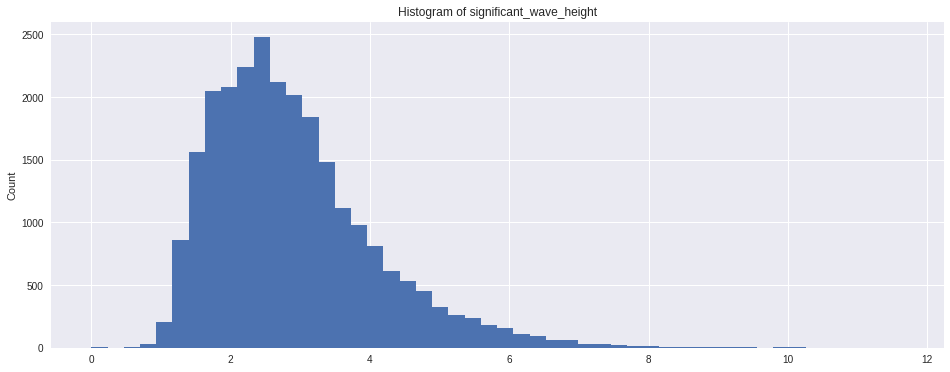

In [178]:
#plot histotgram of signficant wave height

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

#ds['significant_wave_height'].plot(linestyle = 'None', 
#                                   marker='.', 
#                                   markersize=1,
#                                   ax=ax)

ds['significant_wave_height'].plot.hist(bins=50)
                                 

Text(0,0.5,u'Wave Height[m]')

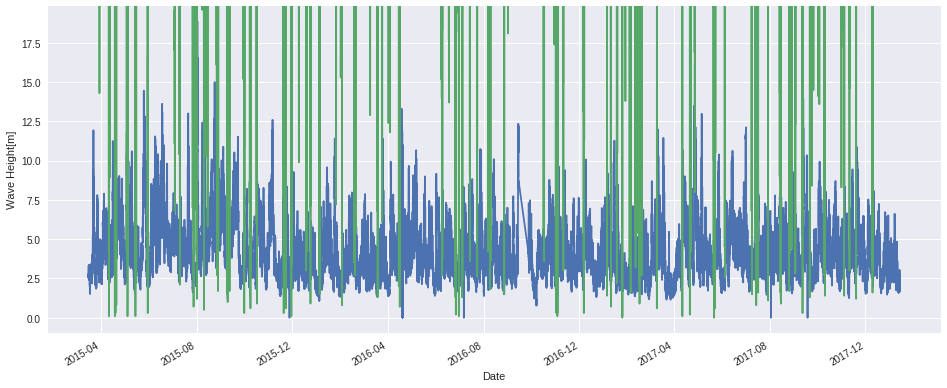

In [183]:
#plot signficant wavve height

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['max_wave_height'].plot()
ds['significant_wave_height'].plot()
plt.xlabel('Date')
plt.ylabel('Wave Height[m]')




Text(0,0.5,u'Wave Height[m]')

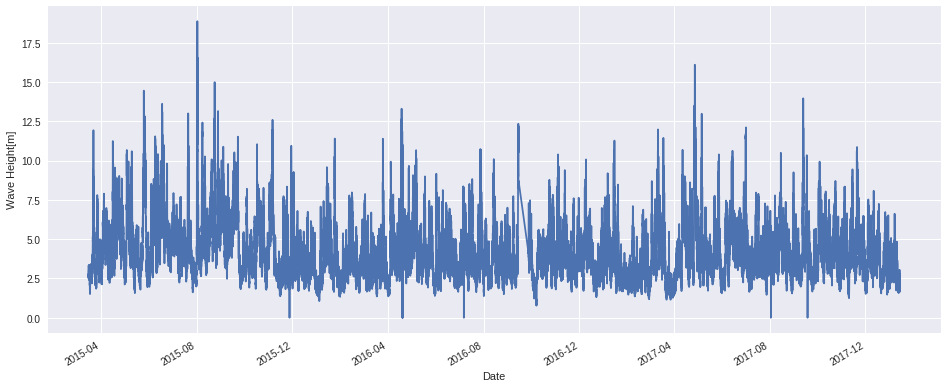

In [72]:
#plot signficant wavve height

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['max_wave_height'].plot()
plt.xlabel('Date')
plt.ylabel('Wave Height[m]')


Text(0,0.5,u'Wave Height[m]')

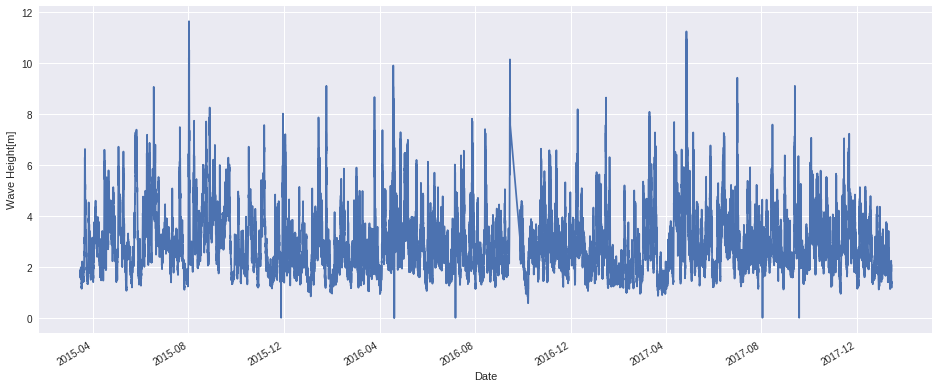

In [73]:
#plot signficant wavve height

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['significant_wave_height'].plot()
plt.xlabel('Date')
plt.ylabel('Wave Height[m]')


Text(0,0.5,u'Wave Direction')

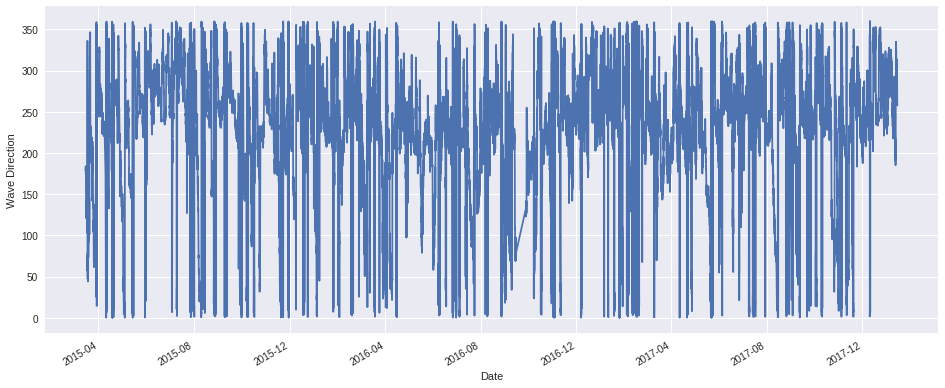

In [188]:
#plot signficant wavve height

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['mean_direction'].plot()
plt.xlabel('Date')
plt.ylabel('Wave Direction')

Text(0,0.5,u'Wave Spread')

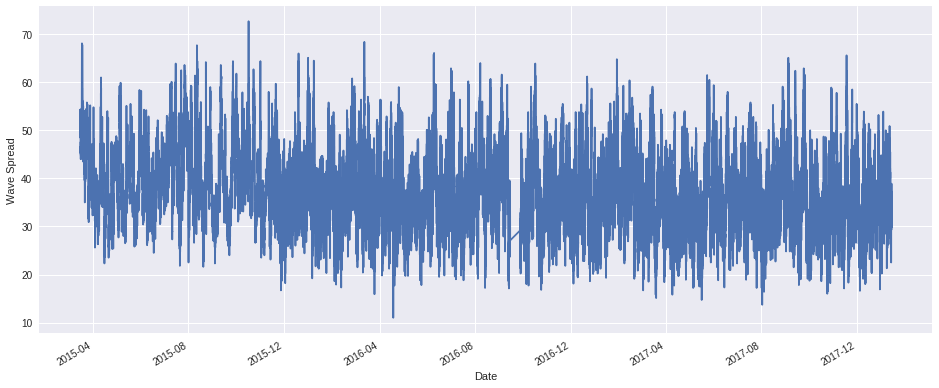

In [196]:
#plot signficant wavve height

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['mean_spread'].plot()
plt.xlabel('Date')
plt.ylabel('Wave Spread')

Text(0,0.5,u'Peak_wave_period')

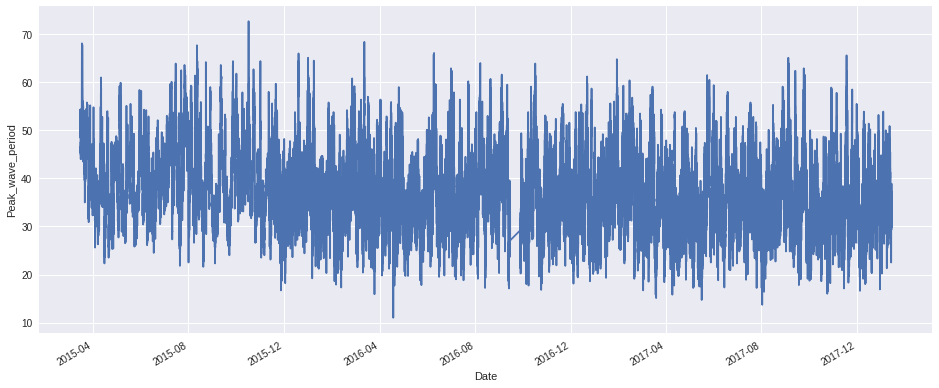

In [197]:
#plot peak wave period

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['peak_wave_period'].plot()
plt.xlabel('Date')
plt.ylabel('Peak_wave_period')

Text(0,0.5,u'number of zero crossings')

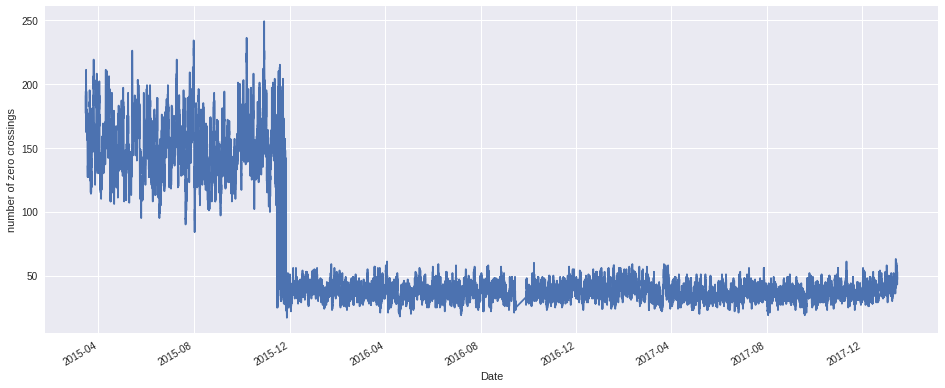

In [237]:
#plot signficant wavve height

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)

ds['number_zero_crossings'].plot()
plt.xlabel('Date')
plt.ylabel('number of zero crossings')



In [62]:
# calculate abnormality index

AI = Hmax/Hs
AI[0]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


1.8595506

Text(0.5,0,u'Date')

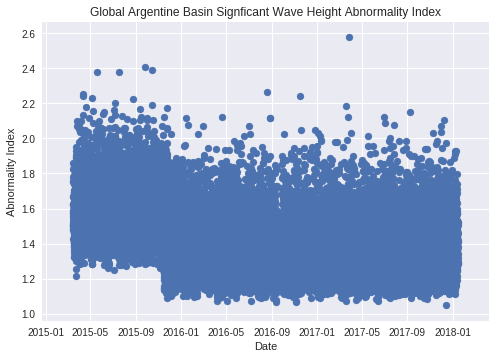

In [134]:
plt.scatter(t,AI)
plt.title('Global Argentine Basin Signficant Wave Height Abnormality Index')
plt.ylabel('Abnormality Index')
plt.xlabel('Date')

(array([  4.,   0.,   2.,  16.,  15.,  68., 156., 259., 391., 482., 533.,
        480., 525., 463., 399., 367., 294., 233., 182., 154., 137.,  96.,
         85.,  73.,  68.,  36.,  39.,  29.,  30.,  27.,  17.,  16.,  11.,
         14.,   8.,   5.,   5.,   3.,   3.,   3.,   3.,   1.,   2.,   0.,
          3.,   0.,   1.,   0.,   2.,   1.]),
 array([ 0.        ,  0.20299999,  0.40599998,  0.60899998,  0.81199997,
         1.01499996,  1.21799995,  1.42099995,  1.62399994,  1.82699993,
         2.02999992,  2.23299992,  2.43599991,  2.6389999 ,  2.84199989,
         3.04499989,  3.24799988,  3.45099987,  3.65399986,  3.85699986,
         4.05999985,  4.26299984,  4.46599983,  4.66899982,  4.87199982,
         5.07499981,  5.2779998 ,  5.48099979,  5.68399979,  5.88699978,
         6.08999977,  6.29299976,  6.49599976,  6.69899975,  6.90199974,
         7.10499973,  7.30799973,  7.51099972,  7.71399971,  7.9169997 ,
         8.11999969,  8.32299969,  8.52599968,  8.72899967,  8.93199966,
 

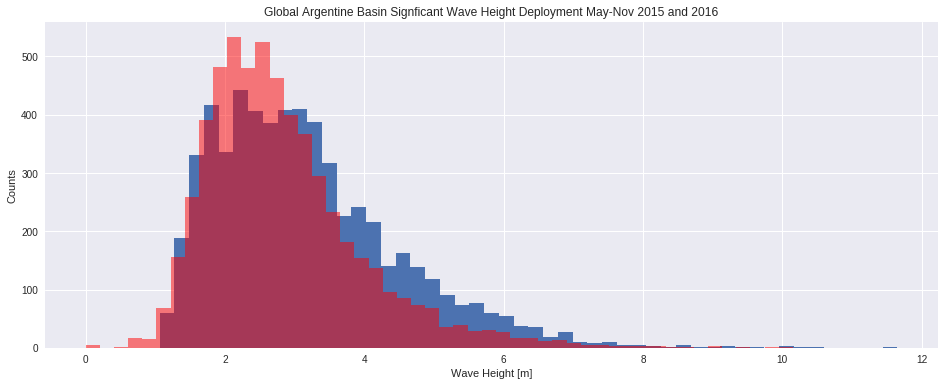

In [133]:
#plot histotgram of signficant wave height may-nov 2015

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)



plt.hist(Hs[0:5870],bins = 50)

plt.title('Global Argentine Basin Signficant Wave Height Deployment May-Nov 2015 and 2016')
plt.ylabel('Counts')
plt.xlabel('Wave Height [m]')
# plt.show()

#plot histotgram of signficant wave height may-nov 2016


plt.hist(Hs2,bins = 50,color="red",alpha = 0.5)



(array([  4.,   0.,   3.,   9.,  16.,  55., 126., 215., 325., 416., 448.,
        512., 494., 423., 432., 350., 333., 284., 222., 194., 149., 117.,
        115.,  84.,  67.,  60.,  48.,  40.,  43.,  34.,  20.,  16.,  13.,
         15.,  15.,   7.,   7.,   4.,   4.,   1.,   8.,   2.,   2.,   1.,
          1.,   4.,   1.,   1.,   0.,   1.]),
 array([ 0.        ,  0.26620001,  0.53240002,  0.79860003,  1.06480003,
         1.33100004,  1.59720005,  1.86340006,  2.12960007,  2.39580008,
         2.66200008,  2.92820009,  3.1944001 ,  3.46060011,  3.72680012,
         3.99300013,  4.25920013,  4.52540014,  4.79160015,  5.05780016,
         5.32400017,  5.59020018,  5.85640018,  6.12260019,  6.3888002 ,
         6.65500021,  6.92120022,  7.18740023,  7.45360023,  7.71980024,
         7.98600025,  8.25220026,  8.51840027,  8.78460028,  9.05080029,
         9.31700029,  9.5832003 ,  9.84940031, 10.11560032, 10.38180033,
        10.64800034, 10.91420034, 11.18040035, 11.44660036, 11.71280037,
 

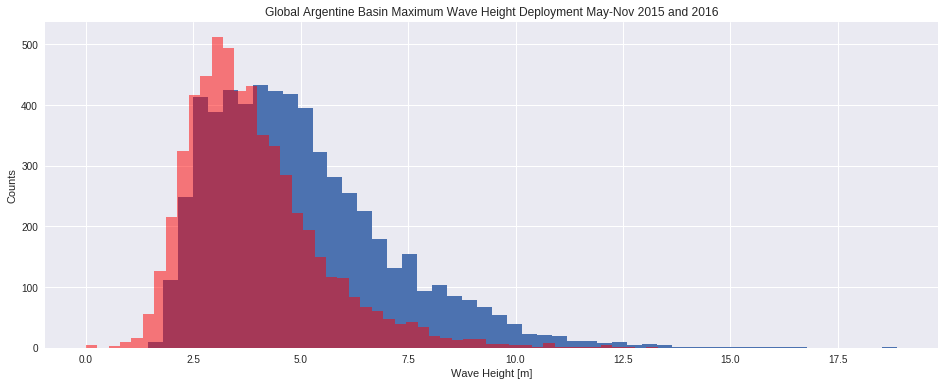

In [132]:
#plot histotgram of maximum wave height may-nov 2015

fig, ax = plt.subplots(1)
fig.set_size_inches(16, 6)



plt.hist(Hmax[0:5870],bins = 50)

plt.title('Global Argentine Basin Maximum Wave Height Deployment May-Nov 2015 and 2016')
plt.ylabel('Counts')
plt.xlabel('Wave Height [m]')
# plt.show()

#plot histotgram of signficant wave height may-nov 2016


plt.hist(Hmax2,bins = 50,color="red",alpha = 0.5)



In [160]:
ds3 = ds.sel(time=slice('2017-03-21', '2017-4-01'))
ds3.time

<xarray.DataArray 'time' (time: 288)>
array(['2017-03-21T00:07:48.451000320', '2017-03-21T01:07:46.474999808',
       '2017-03-21T02:07:46.504999936', ..., '2017-04-01T21:07:47.749000192',
       '2017-04-01T22:07:46.776999936', '2017-04-01T23:07:49.808000000'],
      dtype='datetime64[ns]')
Coordinates:
    obs      (time) int64 dask.array<shape=(288,), chunksize=(288,)>
  * time     (time) datetime64[ns] 2017-03-21T00:07:48.451000320 ...
    lat      (time) float64 dask.array<shape=(288,), chunksize=(288,)>
    lon      (time) float64 dask.array<shape=(288,), chunksize=(288,)>
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T

In [0]:
# extract just the data into an array that can then be manipulated

wv_d3 = ds3['mean_direction'].values
Hs3 = ds3['significant_wave_height'].values
Hmax3 = ds3['max_wave_height'].values
t3 = ds3['time'].values
AI3 = Hmax3/Hs3


Text(0.5,0,u'Date')

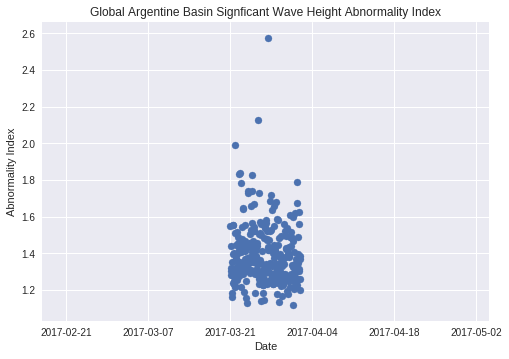

In [162]:
plt.scatter(t3,AI3)
plt.title('Global Argentine Basin Signficant Wave Height Abnormality Index')
plt.ylabel('Abnormality Index')
plt.xlabel('Date')

UsageError: Line magic function `%plt.scatter` not found.


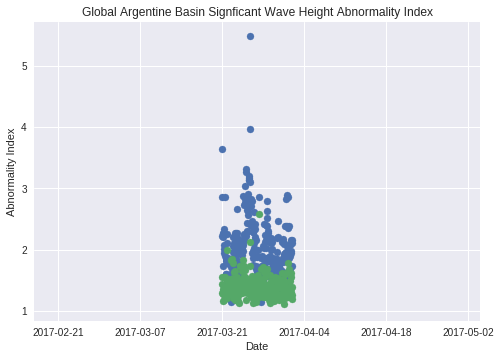

In [165]:
plt.scatter(t3,Hmax3)
plt.scatter(t3,AI3)
plt.title('Global Argentine Basin Signficant Wave Height Abnormality Index')
plt.ylabel('Abnormality Index')
plt.xlabel('Date')
%plt.scatter(t3,Hs3)

Text(0.5,0,u'Date')

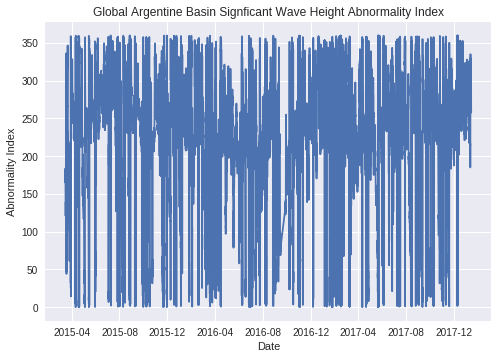

In [181]:
plt.plot(t,wv_d)
plt.title('Global Argentine Basin Signficant Wave Height Abnormality Index')
plt.ylabel('Abnormality Index')
plt.xlabel('Date')

Text(0.5,0,u'Date')

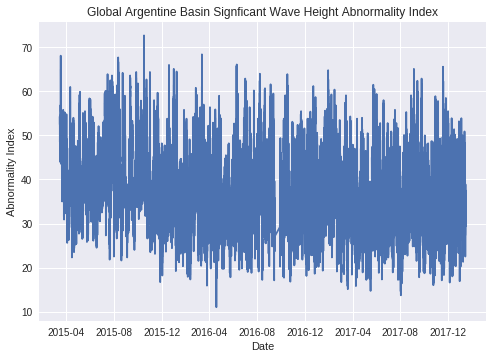

In [191]:
plt.plot(t,wv_spd)
plt.title('Global Argentine Basin Signficant Wave Height Abnormality Index')
plt.ylabel('Abnormality Index')
plt.xlabel('Date')



Text(0.5,0,u'Wave Direction')

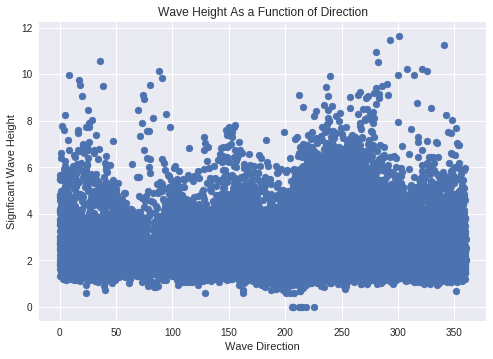

In [235]:

plt.scatter(wv_d,Hs)
plt.title('Wave Height As a Function of Direction')
plt.ylabel('Signficant Wave Height')
plt.xlabel('Wave Direction')


u'https://opendap.oceanobservatories.org/thredds/catalog/ooi/hpotter@tamu.edu/20180524T181844-GA01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

request completed
CPU times: user 4.18 s, sys: 307 ms, total: 4.48 s
Wall time: 7min 35s


[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/hpotter@tamu.edu/20180524T181844-GA01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0003_GA01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20161027T014720.743000-20180114T102330.970000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/hpotter@tamu.edu/20180524T181844-GA01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0003_GA01SUMO-RID16-04-VELPTA000-recovered_host-velpt_ab_dcl_instrument_recovered_20161027T020000-20170324T223325.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/hpotter@tamu.edu/20180524T181844-GA01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0002_GA01SUMO-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered_20151114T210631.697000-20161108T100305.770000.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/hpotter@tamu.edu/201

InvalidIndexError: ignored